# Grupo 5 -   Model - LSTM



## Sumário

- **1. Setup**

- **2. Carregamento e Preparação dos Dados**
  - **2.1 Carregamento dos dados**
  - **2.2 Preparação dos dados**
  - **2.3 Divisão dos dados**
  - **2.4 Tokenização**
  - **2.5 Normalização**
  - **2.6 Categorizar Labels**

- **3. Rede Neural Classificação**
  - **3.1 Definição da rede neural**
  - **3.2 Treinamento da rede neural**

- **4. Resultados**
  - **4.1 Avaliação do modelo**
    - **4.1.2 LSTM**
      - **4.1.2.1 Acompanhamento por época**
      - **4.1.2.2 Comparação Métricas**
      - **4.1.2.3 Matriz de confusão**


- **5. Predições**
  - **5.1 LSTM**

# 1. Setup

Seção para realizar a prepração do ambiente de desenvolvimento, realizando a conexão com o Google Drive e importando as bibliotecas necessárias.



In [1]:
# Montagem do drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importar bibliotecas
import time
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Carregamento e Preparação dos Dados

Nesta seção é feito o carregamento da base de dados que está salva no drive compartilhado da turma, e fazendo todo o pré processamento dos dados, como separar em treino e teste, tokenizar, normalizar os paddings para utilizar no modelo com Embedding e transformando para número as intenções.

## 2.1 Carregamento dos Dados

In [3]:
# Carregar os dados
PATH = '/content/drive/Shareddrives/Grupo_05/base_aug_20240918_v1.xlsx'
base = pd.read_excel(PATH)

In [4]:
# Exibir as primeiras linhas do dataset
base = base[['Intencao', 'Texto']]
base.head()

,Intencao,Texto
0,Acesso a conta,Atualizei os site e agora como acessar minha c...
1,Acesso a conta,Boa tarde Eu gostaria usar o aplicativo da bra...
2,Acesso a conta,Boa tarde Por gentileza alguém pode me ajudar ...
3,Acesso a conta,Boa tarde Jessica!Consegui logar minha conta!M...
4,Acesso a conta,Boa tarde estou tendo problema com o pin eu nã...


## 2.2 Preparação dos dados

In [5]:
# Retirando valores nulos e duplicados
base = base.dropna()
base = base.drop_duplicates(subset='Texto')
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3445 entries, 0 to 3446
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Intencao  3445 non-null   object
 1   Texto     3445 non-null   object
dtypes: object(2)
memory usage: 80.7+ KB


In [6]:
# Retirando intenções que possuem menos de 10 colunas
base[base['Intencao'] != 'Envio via Deposit Code']
base[base['Intencao'] != 'Regras do servico']
base[base['Intencao'] != 'Dificuldades com utilizacao do App']

,Intencao,Texto
0,Acesso a conta,Atualizei os site e agora como acessar minha c...
1,Acesso a conta,Boa tarde Eu gostaria usar o aplicativo da bra...
2,Acesso a conta,Boa tarde Por gentileza alguém pode me ajudar ...
3,Acesso a conta,Boa tarde Jessica!Consegui logar minha conta!M...
4,Acesso a conta,Boa tarde estou tendo problema com o pin eu nã...
...,...,...
3442,Reembolso,"conta meu marido,eu do como errado, depositar ..."
3443,Reembolso,a com o ->minha consegue saldo reembolso aplic...
3444,Reembolso,É possível solicitar O reembolso diretamente c...
3445,Reembolso,"boa tarde Uma informação, como não consegui en..."


## 2.3 Divisão dos dados

In [7]:
# Definição de labels e dados que serão utilizados para o treinamento
quests = base['Texto'].astype(str).values
labels = base['Intencao'].values

In [8]:
# Dividir os dados em conjuntos de treinamento e teste sendo 80% e 20%
train_data, test_data, train_labels, test_labels = train_test_split(quests, labels, test_size=0.30, random_state=42)

## 2.4 Tokenização

In [9]:
# Tokenização das perguntas com um token OOV para palavras desconhecidas
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_data)  # Tokeniza o texto
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

In [10]:
# Visualizando as sequências geradas
print("Sequências de treino:", train_sequences)
print("Sequências de teste:", test_sequences)

Sequências de treino: [[29, 100, 102, 1891, 22, 297], [15, 12, 4, 13, 604, 24, 196, 124, 30, 347, 104, 580, 54, 66, 11, 1508, 36, 920, 172, 1103, 23, 10, 581, 134, 17, 1509, 2, 60, 207, 423, 24, 185, 697, 424, 19, 4, 698, 506, 920, 1103, 29], [206, 129, 40, 10, 101, 87], [62, 558, 228, 44, 507, 1510, 47, 91, 23, 47, 323, 10, 791, 44, 314, 699, 47, 10, 791, 17, 98, 441, 23, 91], [15, 12, 4, 273, 253, 193, 49, 197, 366, 103, 118, 31, 26, 651, 11, 34, 173, 29], [15, 119, 115, 120, 35, 625, 216, 652, 7, 93], [30, 88, 77, 11, 119, 115, 120, 2, 18, 626], [186, 145, 488, 700, 7, 143], [15, 12, 653, 4, 306, 3, 136, 23, 525, 13, 376, 5, 2, 53, 377, 48, 1511, 7, 53, 146, 406, 526, 3, 1892, 42, 1893, 4, 239, 66, 1512, 48, 85], [15, 12, 2, 163, 51, 28, 92, 100, 22, 80, 94, 4, 792, 3, 1894, 7, 22, 149, 140, 746, 1895, 489, 8, 490, 5, 1513, 2, 22, 80, 1277, 348, 229, 223, 8, 243, 7, 22, 113, 149, 140, 5, 28, 92, 100, 58, 7, 22, 1104, 280, 198, 25, 36, 80, 3, 13, 65, 21, 61, 116, 137, 130, 191, 9, 17

## 2.5 Normalização

In [11]:
# Padding para garantir que todas as sequências tenham o mesmo comprimento
max_seq_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post')

## 2.6 Categorizar as labels

In [12]:
# Codificação das labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [13]:
# Conversão para categórico
train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

In [14]:
# Salvar tamanho do vocabulário
vocab_size = len(tokenizer.word_index) + 1

# 3. Rede Neural Classificação

Nesta seção foi construída a rede neural para a classificação de intenção a partir das perguntas que foram fornecida na base de dados.



## 3.1 Definição da rede neural

A função create_neural_network constrói uma rede neural utilizando uma arquitetura flexível e parametrizável. O modelo começa com uma camada de embedding, responsável por converter as palavras em vetores de dimensão out_dim, sendo o tamanho máximo da sequência definido por max_seq_length e o tamanho do vocabulário por vocab_size. Após isso, a rede inclui uma camada recorrente, que pode ser configurada como LSTM, GRU ou SimpleRNN, dependendo do valor do parâmetro rnn_type, com o número de unidades dessa camada definido por units. Para lidar com o overfitting, é aplicada uma camada de dropout com a taxa definida por dropout.

Caso a camada escolhida seja LSTM ou GRU, a rede usa a versão Bidirectional, que permite que o modelo aprenda relações tanto na direção da sequência quanto na inversa. No caso da RNN simples, a mesma lógica é aplicada. O modelo então adiciona duas camadas densas adicionais: a primeira com 128 neurônios e a segunda com 64 neurônios, ambas utilizando a função de ativação ReLU, seguidas por camadas de dropout para melhorar a regularização.

A camada final do modelo é uma camada de saída, que possui o número de neurônios correspondente ao número de classes a serem previstas (output_classes), e utiliza a ativação softmax para produzir as probabilidades para cada classe.

Por fim, o modelo é compilado utilizando o otimizador escolhido, podendo ser o Adam ou o RMSprop, com a taxa de aprendizado configurável via o parâmetro learning_rate. A função retorna o modelo pronto para o treinamento, já com a função de perda categorical_crossentropy e a métrica de desempenho accuracy configuradas.

In [15]:
def create_neural_network(vocab_size, max_seq_length, out_dim, output_classes, rnn_type='LSTM', units=128, dropout=0.5, optimizer='adam', learning_rate=0.001):
    """
    Cria um modelo de rede neural com base em hiperparâmetros configuráveis, incluindo duas camadas adicionais.

    Args:
        vocab_size (int): Tamanho do vocabulário.
        max_seq_length (int): Tamanho máximo da sequência.
        out_dim (int): Dimensão dos embeddings.
        output_classes (int): Número de classes de saída.
        rnn_type (str): Tipo de camada RNN, 'LSTM', 'GRU' ou 'SimpleRNN'. Default é 'LSTM'.
        units (int): Número de unidades na camada RNN. Default é 128.
        dropout (float): Taxa de dropout. Default é 0.5.
        optimizer (str): Otimizador a ser usado. Default é 'adam'.
        learning_rate (float): Taxa de aprendizado. Default é 0.001.

    Returns:
        model (Sequential): O modelo de rede neural configurado.
    """

    model = Sequential()
    # Camada de Embedding
    model.add(Embedding(input_dim=vocab_size, output_dim=out_dim, input_length=max_seq_length, trainable=True))

    # Camada RNN (LSTM, GRU ou SimpleRNN)
    if rnn_type == 'LSTM':
        model.add(Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=0.2)))
    elif rnn_type == 'GRU':
        model.add(Bidirectional(GRU(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=0.2)))
    elif rnn_type == 'SimpleRNN':
        model.add(Bidirectional(SimpleRNN(units=units, return_sequences=False, dropout=dropout)))

    # Primeira camada densa adicional
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))

    # Segunda camada densa adicional
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout))

    # Camada final de classificação
    model.add(Dense(output_classes, activation='softmax'))

    # Configurando otimizador
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model


A função train_neural_network realiza o treinamento de um modelo de rede neural usando os dados de treino e validação. O treinamento é configurado com um número definido de épocas (padrão 500) e tamanho de batch (padrão 128). A função utiliza early stopping para interromper o treinamento caso o desempenho em validação não melhore por 20 épocas. Ao final, retorna o histórico de treinamento, o tempo total gasto e o uso de memória durante o processo.

In [16]:
def train_neural_network(model, train_padded, train_labels_categorical, test_padded, test_labels_categorical, epochs=500, batch_size=128):
    """
    Treina o modelo de rede neural.

    Args:
        model (Sequential): Modelo criado pela função create_neural_network.
        train_padded (np.array): Dados de treinamento com padding aplicado.
        train_labels_categorical (np.array): Labels de treinamento em formato categórico.
        test_padded (np.array): Dados de validação com padding aplicado.
        test_labels_categorical (np.array): Labels de validação em formato categórico.
        epochs (int): Número de épocas para treinamento. Default é 500.
        batch_size (int): Tamanho do batch. Default é 128.

    Returns:
        history (History): Histórico de treinamento.
        elapsed_time (float): Tempo decorrido durante o treinamento.
        memory_usage (float): Uso de memória durante o treinamento em MB.
    """

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    start_time = time.time()
    history = model.fit(train_padded, train_labels_categorical, epochs=epochs, validation_data=(test_padded, test_labels_categorical),
                        batch_size=batch_size, callbacks=[early_stopping])
    end_time = time.time()
    elapsed_time = end_time - start_time

    process = psutil.Process()
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Converter para MB

    return history, elapsed_time, memory_usage


## 3.2 Treinamento da rede neural

Para o treinamento da rede neural, foram utilizados os dados de treino e teste previamente pré-processados. Três diferentes arquiteturas de redes neurais recorrentes foram treinadas: SimpleRNN, GRU e LSTM, cada uma com seus próprios parâmetros e características. O treinamento foi realizado por 50 épocas e com um batch size de 128. Além disso, foi adicionado o Early Stopping, com base no desempenho em dados de validação, para evitar o problema de overfitting, interrompendo o treinamento caso a performance do modelo não melhore após um número pré-definido de épocas consecutivas.

In [17]:
# SimpleRNN
modelRNN = create_neural_network(vocab_size=vocab_size, max_seq_length=max_seq_length, out_dim=300, output_classes=len(label_encoder.classes_), rnn_type='SimpleRNN')

# GRU
modelGRU = create_neural_network(vocab_size=vocab_size, max_seq_length=max_seq_length, out_dim=300, output_classes=len(label_encoder.classes_), rnn_type='GRU')

# LSTM
modelLSTM = create_neural_network(vocab_size=vocab_size, max_seq_length=max_seq_length, out_dim=300, output_classes=len(label_encoder.classes_), rnn_type='LSTM')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
'''
historyRNN, elapsed_timeRNN, memory_usageRNN = train_neural_network(
    modelRNN,
    train_padded,
    train_labels_categorical,
    test_padded,
    test_labels_categorical,
    epochs=50,
    batch_size=32
)
'''

historyLSTM, elapsed_timeLSTM, memory_usageLSTM = train_neural_network(
    modelLSTM,
    train_padded,
    train_labels_categorical,
    test_padded,
    test_labels_categorical,
    epochs=50,
    batch_size=32
)
'''
historyGRU, elapsed_timeGRU, memory_usageGRU = train_neural_network(
    modelGRU,
    train_padded,
    train_labels_categorical,
    test_padded,
    test_labels_categorical,
    epochs=50,
    batch_size=32
)
'''

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 67s 741ms/step - accuracy: 0.1347 - loss: 2.7983 - val_accuracy: 0.1770 - val_loss: 2.7017
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 723ms/step - accuracy: 0.1885 - loss: 2.6065 - val_accuracy: 0.2631 - val_loss: 2.3742
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 54s 710ms/step - accuracy: 0.2705 - loss: 2.2872 - val_accuracy: 0.4275 - val_loss: 1.8372
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 695ms/step - accuracy: 0.3904 - loss: 1.8525 - val_accuracy: 0.5406 - val_loss: 1.4171
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 85s 730ms/step - accuracy: 0.5088 - loss: 1.4115 - val_accuracy: 0.6112 - val_loss: 1.1545
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 80s 702ms/step - accuracy: 0.5764 - loss: 1.1829 - val_accuracy: 0.6712 - val_loss: 1.0397
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 82s 699ms/step - accuracy: 0.6652 - loss: 0.9416 - val_accuracy: 0.6731 - val_loss: 0.9932
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 83s 714ms/step - accuracy: 0.6902 - loss: 0.9168 - val_accu

'\nhistoryGRU, elapsed_timeGRU, memory_usageGRU = train_neural_network(\n    modelGRU,\n    train_padded,\n    train_labels_categorical,\n    test_padded,\n    test_labels_categorical,\n    epochs=50,\n    batch_size=32\n)\n'

# 4. Resultados

Para avaliação do modelo enquanto ele treina foi utilizado a acurácia, pois ela define quanto que o modelo está acertando do total, sendo a mais útil para o atual modelo. Também foi acrescentado outras métricas como Recall, Precision e F1-Score.

**Explicação de cada métrica:**

- Acurácia: Fornece uma visão geral da performance do modelo, indicando o quão bem ele está acertando as previsões em geral.

- Recall: Foca em quantos dos verdadeiros positivos foram identificados, importante quando é crucial capturar todos os casos positivos.

- Precision: Avalia a qualidade das previsões positivas feitas pelo modelo, relevante quando é necessário evitar falsos positivos.

- F1-Score: Oferece uma métrica balanceada que considera tanto a precisão quanto o recall, útil para cenários onde ambos os aspectos são importantes.


## 4.1 Avaliação do modelo





### 4.1.2 LSTM

**Resumo LSTM:**

Acurácia: 78%

Precisão: 78%

Recall: 78%

F1-Score: 74%

In [23]:
# Avaliação do modelo LSTM
lossLSTM, accuracyLSTM = modelLSTM.evaluate(test_padded, test_labels_categorical)
print(f'LSTM - Test Accuracy: {accuracyLSTM:.2f}')
print(f'LSTM - Loss: {lossLSTM:.2f}')

# Previsões
predictionsLSTM = modelLSTM.predict(test_padded)
pred_labelsLSTM = predictionsLSTM.argmax(axis=1)
true_labelsLSTM = test_labels_categorical.argmax(axis=1)

# Cálculo das métricas
precisionLSTM = precision_score(true_labelsLSTM, pred_labelsLSTM, average='weighted')
recallLSTM = recall_score(true_labelsLSTM, pred_labelsLSTM, average='weighted')
f1LSTM = f1_score(true_labelsLSTM, pred_labelsLSTM, average='weighted')

print('\nLSTM - Métricas')
print(f'Precision: {precisionLSTM:.2f}')
print(f'Recall: {recallLSTM:.2f}')
print(f'F1-Score: {f1LSTM:.2f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.8008 - loss: 0.7316
LSTM - Test Accuracy: 0.78
LSTM - Loss: 0.81
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step

LSTM - Métricas
Precision: 0.78
Recall: 0.78
F1-Score: 0.78


#### 4.1.2.1 Acompanhamento por época

A partir desse gráfico percebe-se que o modelo segue tendo um Overfitting, pois a validação fica muito abaixo do conjunto de treino, isso mostra que mesmo com o modelo com 91% de acurácia nas últimas épocas, quando há inserção de dados desconhecidos o modelo não reconhece.


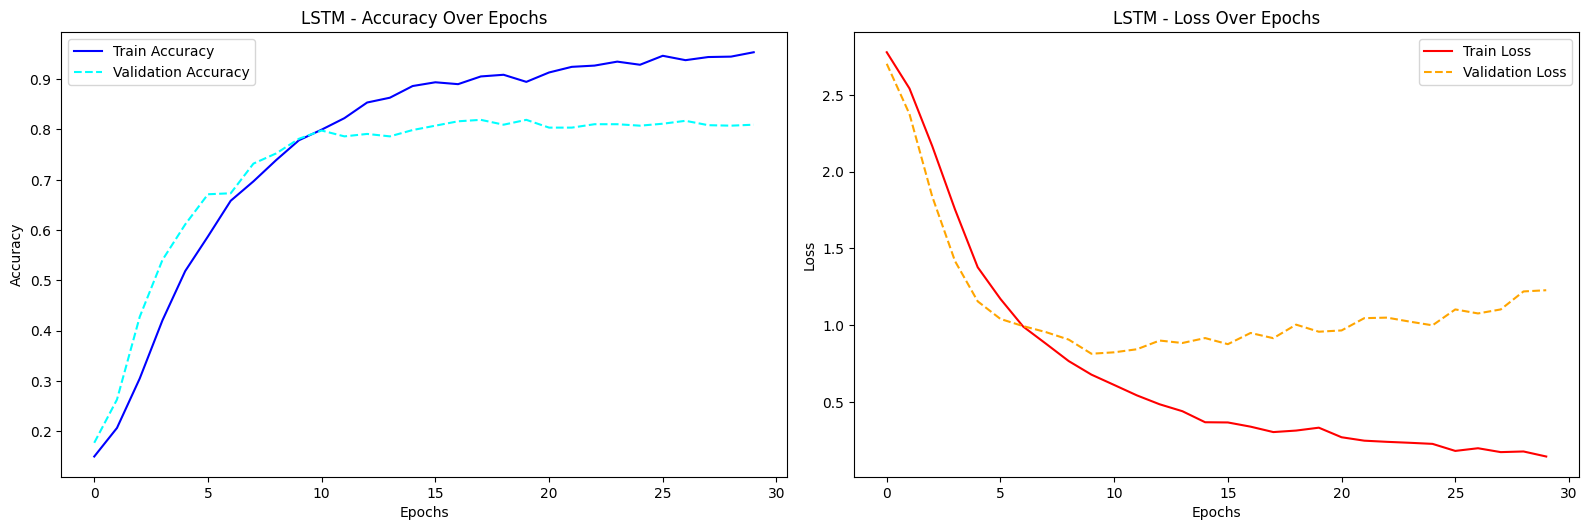

In [24]:
# Gráficos de Acurácia e Perda - LSTM
plt.figure(figsize=(16, 10))

# Gráfico de Acurácia
plt.subplot(2, 2, 1)
plt.plot(historyLSTM.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(historyLSTM.history['val_accuracy'], label='Validation Accuracy', color='cyan', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM - Accuracy Over Epochs')
plt.legend()

# Gráfico de Perda
plt.subplot(2, 2, 2)
plt.plot(historyLSTM.history['loss'], label='Train Loss', color='red')
plt.plot(historyLSTM.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM - Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


#### 4.1.2.2 Comparação Métricas



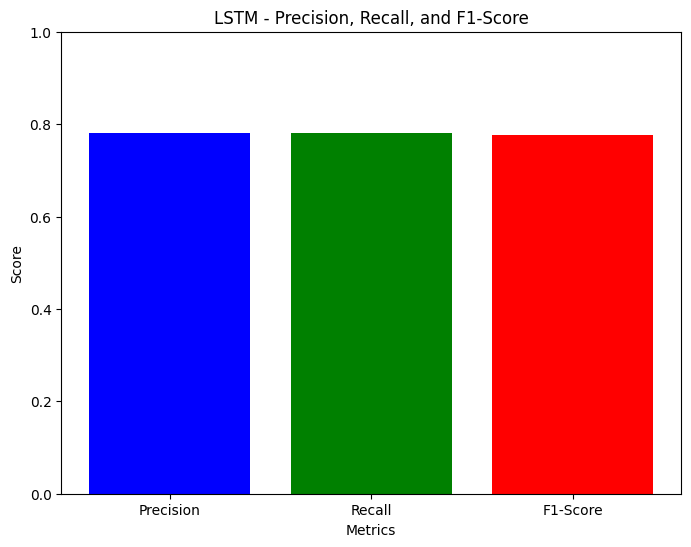

In [25]:
# Gráfico de Barras para as Métricas - LSTM
metricsLSTM = {'Precision': precisionLSTM, 'Recall': recallLSTM, 'F1-Score': f1LSTM}
plt.figure(figsize=(8, 6))
plt.bar(metricsLSTM.keys(), metricsLSTM.values(), color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.title('LSTM - Precision, Recall, and F1-Score')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()

#### 4.1.2.3 Matriz de confusão

A matriz de confusão serve para validação de como o modelo está identificando as classes, percebe-se que o modelo está concentrando apenas em duas classes, evidenciando a falta de generalização das classes. Diferente do modelo de RNN, este modelo tem uma tendência nova que é "Problemas/Duvidas de atualizacao de dados cadastrais", mostrando ser um modelo superior, entretanto a qualidade dos dados inseridos não.



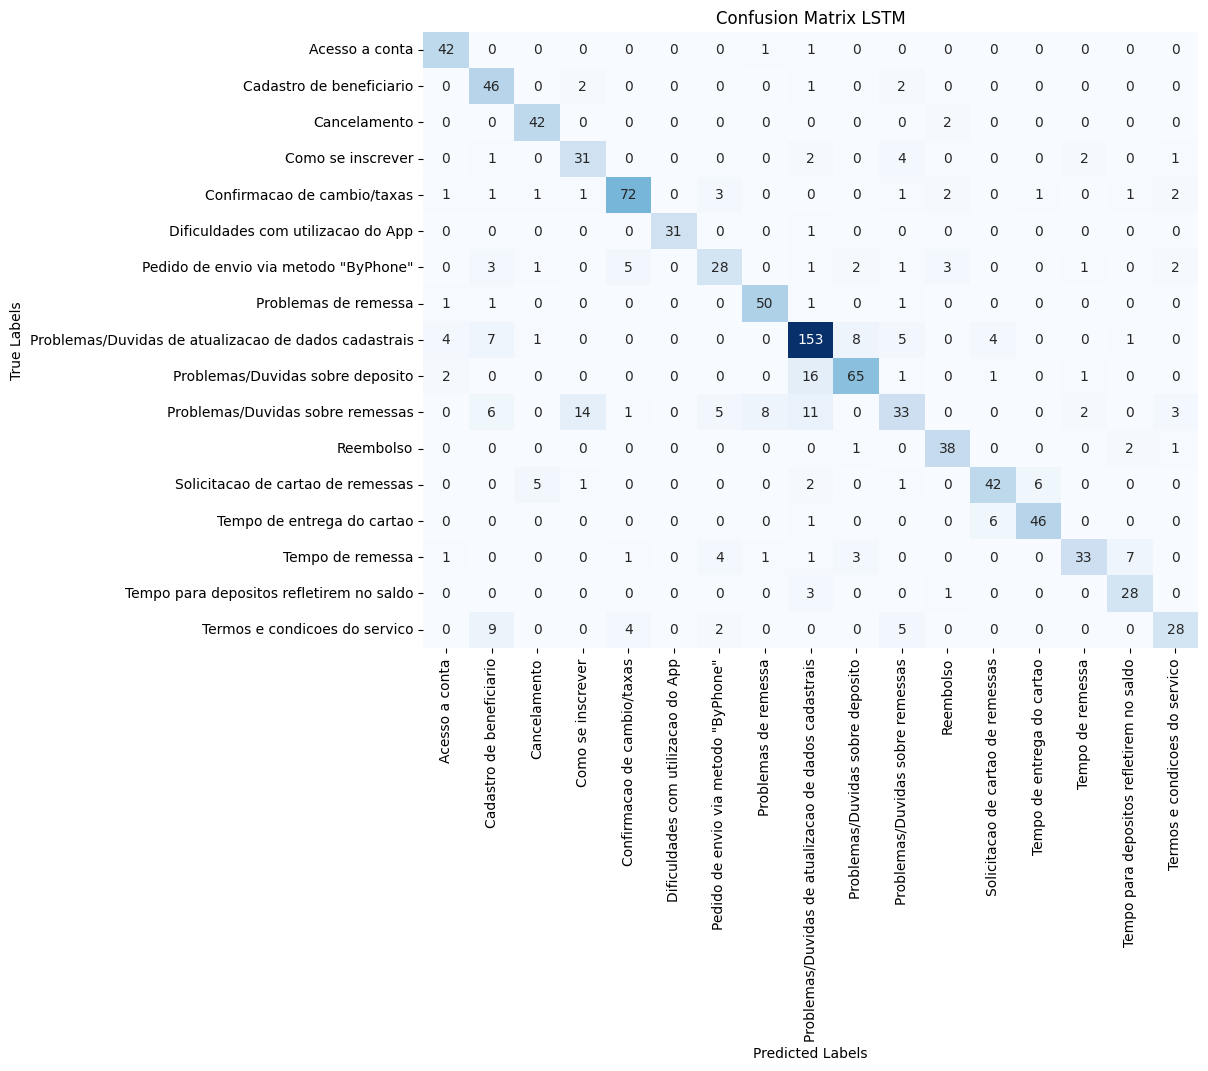

In [26]:
# Matriz de Confusão - LSTM
conf_matrixLSTM = confusion_matrix(true_labelsLSTM, pred_labelsLSTM)

# Mapeamento de índices para rótulos
label_mapping = dict(enumerate(label_encoder.classes_))
labels = list(label_mapping.values())

# Visualize a matriz de confusão com rótulos de classes
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrixLSTM, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix LSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix_LSTM.png', dpi=300, bbox_inches='tight')  # Ajuste a resolução e a margem
plt.show()

# 5. Predições

Nesta seção será realizada as predições de frases que foram separadas pelo modelo, percebe-se que o modelo apresenta inconsistência tendo uma tendência para classificar como "Pedido de envio via metodo "ByPhone"". Isso ocorre porque as classes estão desbalanceadas, tendo maior quantidade de "Pedido de envio via metodo ByPhone".

In [33]:
# 1. Definir os textos a serem classificados
new_texts = [
    "Quando minha remessa será entregue?",  # Exemplo de intenção relacionada a "Tempo de remessa"
    "Como faço para fazer um depósito?",   # Exemplo de intenção relacionada a "Como depositar"
    "Qual o prazo de entrega?",  # Outro exemplo de "Tempo de remessa"
    "Quais são os métodos de depósito aceitos?"  # Outro exemplo de "Como depositar"
]

# 2. Tokenizar e padronizar os novos textos
# Usar o mesmo tokenizador e o parâmetro `max_len` que foi utilizado no treinamento
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_seq_length, padding='post')

# 3. Prever as intenções usando cada um dos modelos

# Previsão usando o modelo LSTM
predictionsLSTM = modelLSTM.predict(new_padded)
pred_labelsLSTM = predictionsLSTM.argmax(axis=1)


# 4. Mapear os índices de previsão para as intenções
label_mapping = dict(enumerate(label_encoder.classes_))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


## 6.1 LSTM

In [32]:
print("Previsões LSTM:")
for i, text in enumerate(new_texts):
    print(f"Texto: {text}")
    print(f"Intenção prevista: {label_mapping[pred_labelsLSTM[i]]}\n")

Previsões LSTM:
Texto: Quando minha remessa será entregue?
Intenção prevista: Pedido de envio via metodo "ByPhone"

Texto: Como faço para fazer um depósito?
Intenção prevista: Problemas/Duvidas de atualizacao de dados cadastrais

Texto: Qual o prazo de entrega?
Intenção prevista: Reembolso

Texto: Quais são os métodos de depósito aceitos?
Intenção prevista: Problemas/Duvidas sobre remessas

